<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/WGan_6464Reds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = Path('/content/drive/MyDrive/red/')
len(os.listdir(path))

191

In [ ]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)
print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
import cv2
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    #img = (img - 127.5) / 127.5
    img = img / 255
    img = tf.image.resize(img, (64, 64))
    return img

In [ ]:
TOTAL=191
BATCH_SIZE=16

In [ ]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [ ]:
dataset = dataset.shuffle(TOTAL).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
dataset = dataset.prefetch(32)

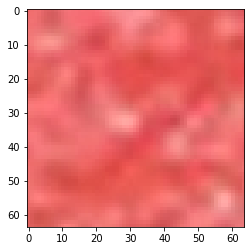

In [ ]:
plt.imshow(next(dataset.as_numpy_iterator())[3])

In [ ]:
next(dataset.as_numpy_iterator())[:BATCH_SIZE].shape

(16, 64, 64, 3)

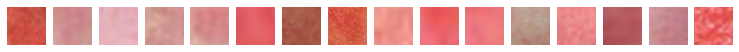

In [ ]:
def show(images):
    fig, ax = plt.subplots(1, BATCH_SIZE, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:BATCH_SIZE])

In [ ]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [ ]:
def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [ ]:
d = critic()
d.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_layer_4 (ConvLayer)    (None, 32, 32, 64)        3200      
                                                                 
 conv_layer_5 (ConvLayer)    (None, 16, 16, 128)       131328    
                                                                 
 conv_layer_6 (ConvLayer)    (None, 8, 8, 256)         524800    
                                                                 
 conv_layer_7 (ConvLayer)    (None, 4, 4, 512)         2098176   
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 1)           8193      
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0   

In [ ]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [ ]:
def generator(input_shape=(1, 1, 128), output_channels=3, dim=64, n_upsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [ ]:
g = generator()
g.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 upsample_block_4 (UpsampleB  (None, 4, 4, 512)        1050112   
 lock)                                                           
                                                                 
 upsample_block_5 (UpsampleB  (None, 8, 8, 256)        2097920   
 lock)                                                           
                                                                 
 upsample_block_6 (UpsampleB  (None, 16, 16, 128)      524672    
 lock)                                                           
                                                                 
 upsample_block_7 (UpsampleB  (None, 32, 32, 64)       131264    
 lock)                                                     

In [ ]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [ ]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [ ]:
EPOCHS = 10
noise_dim = 128

In [ ]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [ ]:
seed = tf.random.normal((16, 1, 1, 128))

In [ ]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    if(epoch % 50 == 0):
      fig, ax = plt.subplots(4, 4, figsize=(10,10))
      for i, a in enumerate(ax.flat):
          a.imshow(predictions[i, :, :, :])
          a.axis('off')
      plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=TOTAL//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
train(dataset, 1)
# 1 epochs

Time for epoch 1 is 5.949994087219238 sec


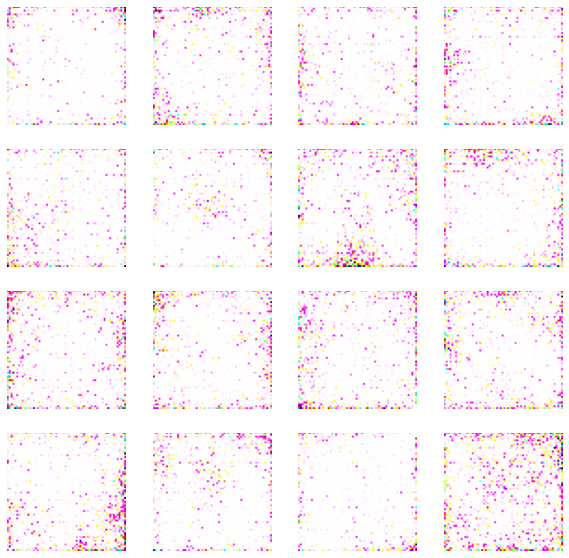

Time for epoch 50 is 1.1823701858520508 sec


In [ ]:
train(dataset, 50)

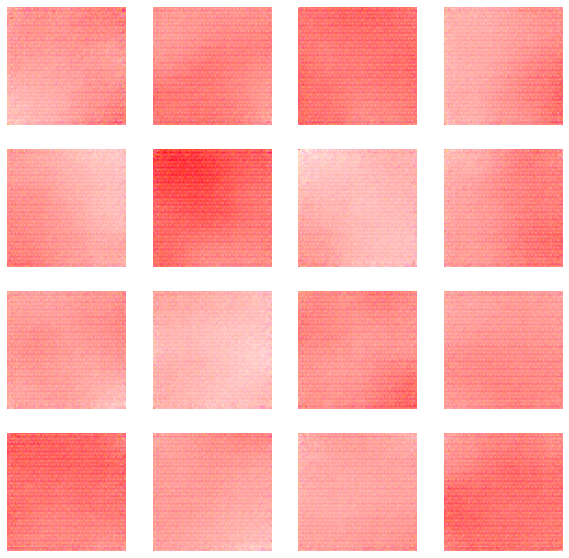

Time for epoch 500 is 1.1889402866363525 sec


In [ ]:
train(dataset, 500)

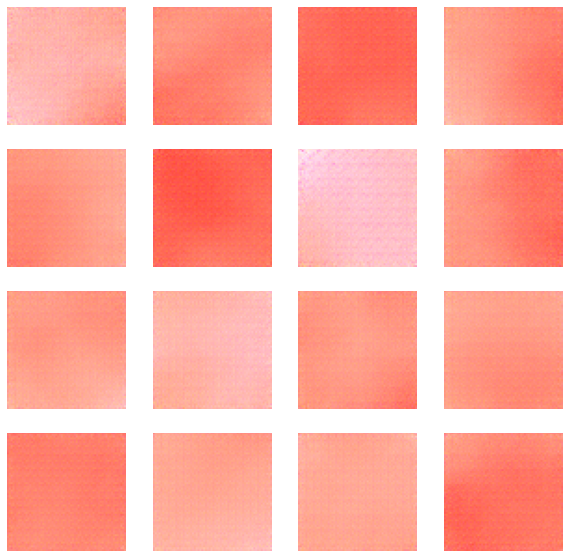

Time for epoch 500 is 1.1705420017242432 sec


In [ ]:
train(dataset, 500)

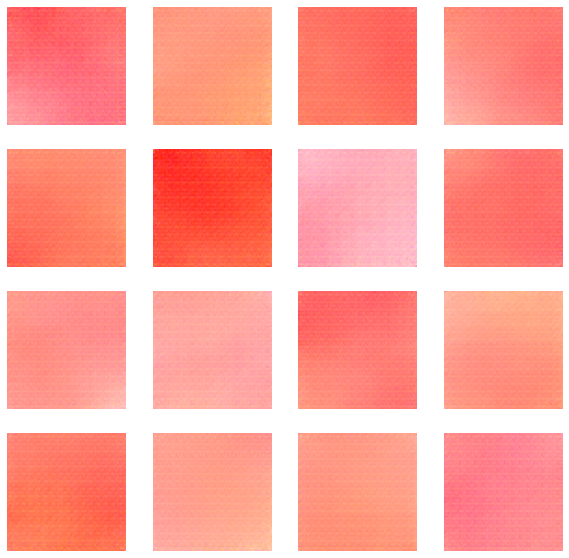

Time for epoch 1000 is 1.156280279159546 sec


In [ ]:
train(dataset, 1000)

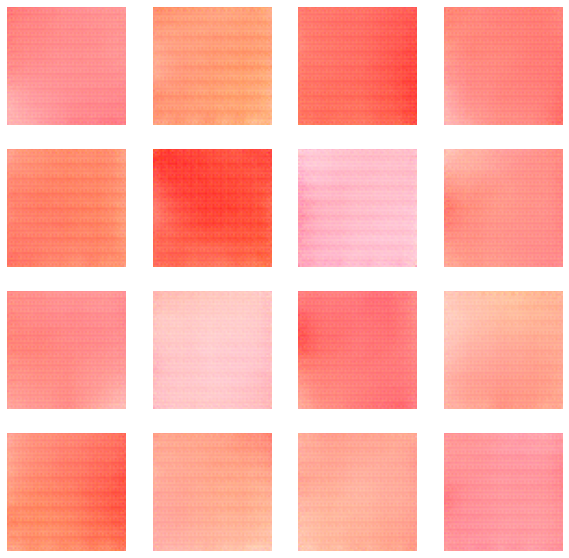

Time for epoch 1000 is 1.3934626579284668 sec


In [ ]:
train(dataset, 1000)

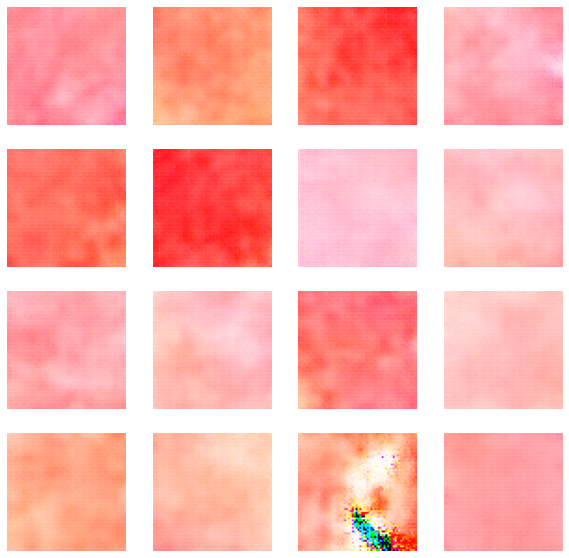

Time for epoch 5000 is 1.169372320175171 sec


In [ ]:
train(dataset, 5000)

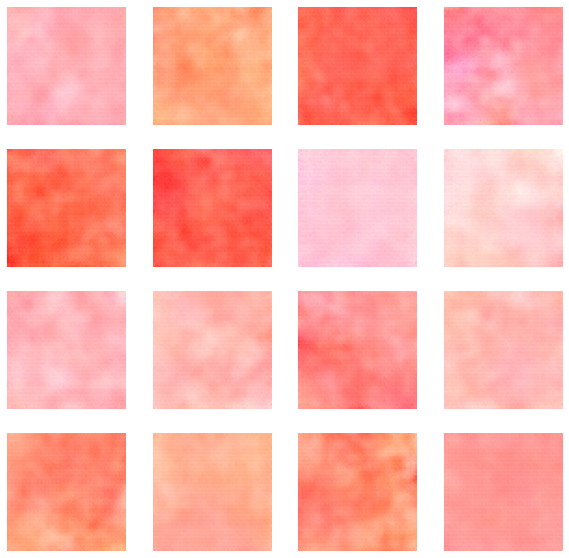

Time for epoch 5000 is 1.1389424800872803 sec


In [ ]:
train(dataset, 5000)

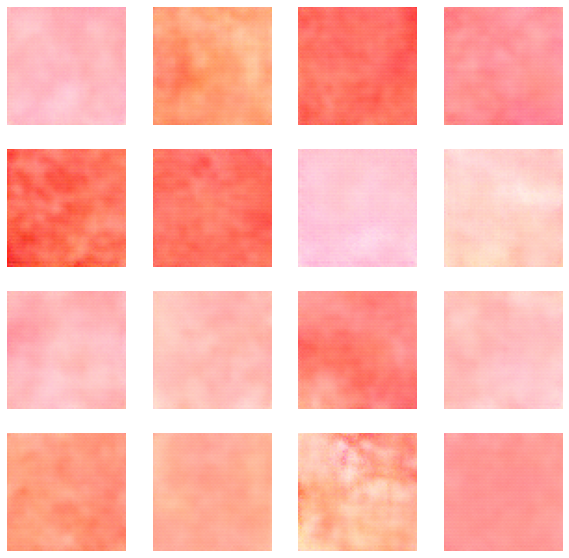

Time for epoch 5000 is 1.365417242050171 sec


In [ ]:
train(dataset, 5000)

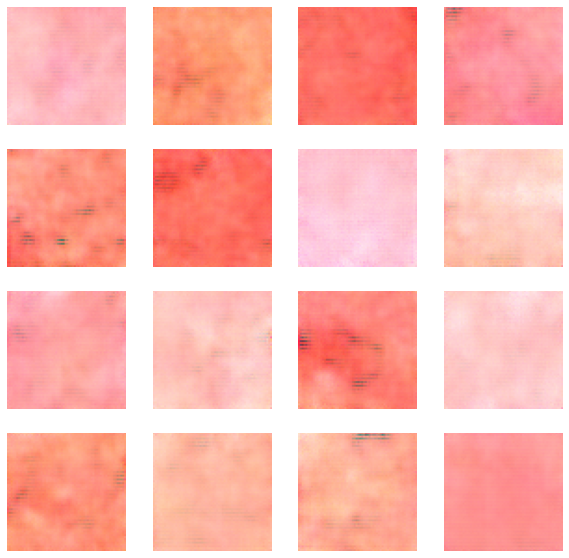

Time for epoch 5000 is 1.1543681621551514 sec


In [ ]:
train(dataset, 5000)

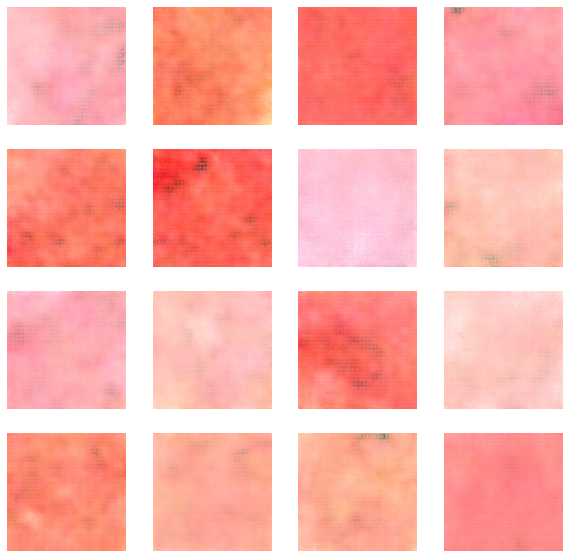

Time for epoch 5000 is 1.1985509395599365 sec


In [ ]:
train(dataset, 5000)

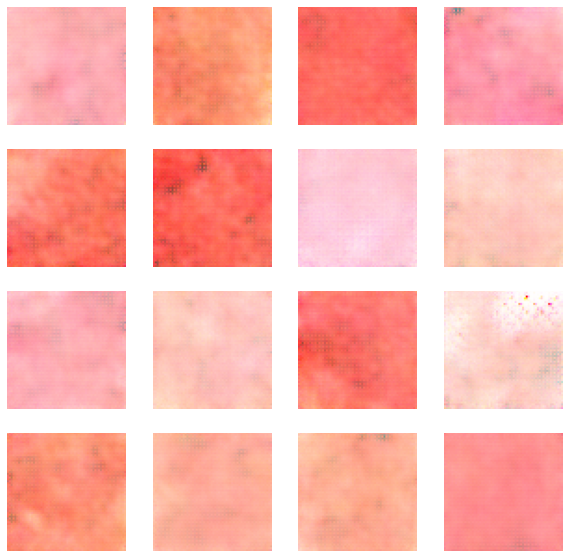

Time for epoch 5000 is 1.411705493927002 sec


In [ ]:
train(dataset, 5000)

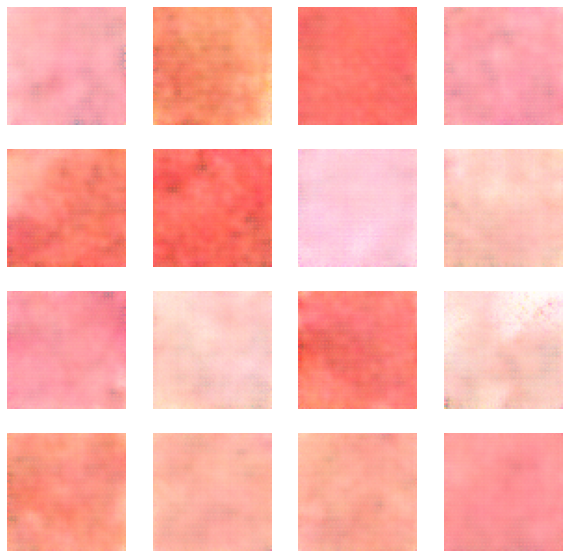

Time for epoch 5000 is 1.1844322681427002 sec


In [ ]:
train(dataset, 5000)

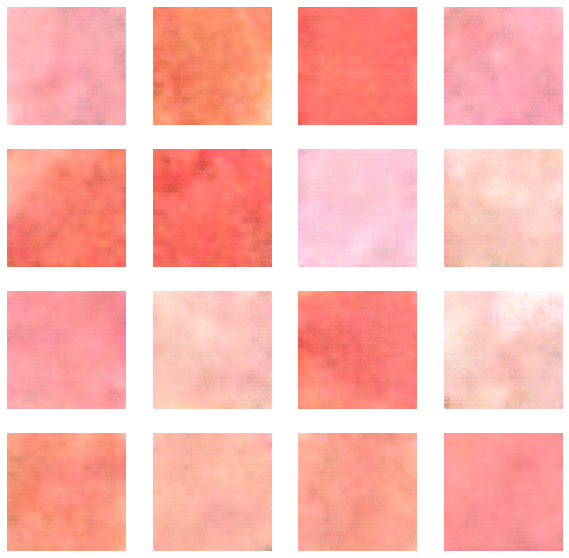

Time for epoch 5000 is 1.186446189880371 sec


In [ ]:
train(dataset, 5000)

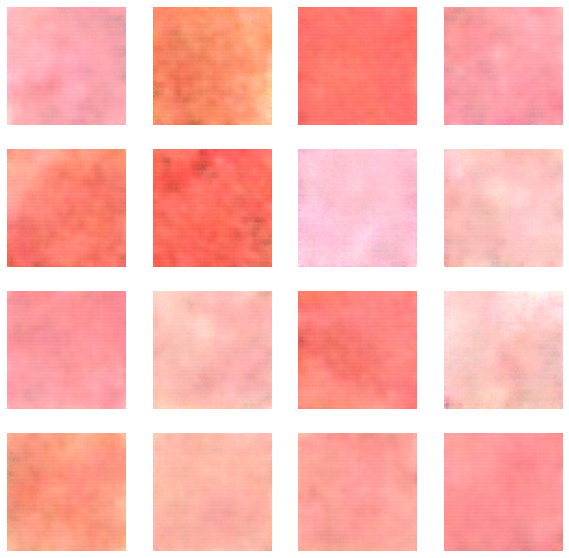

Time for epoch 5000 is 1.3614697456359863 sec


In [ ]:
train(dataset, 5000)

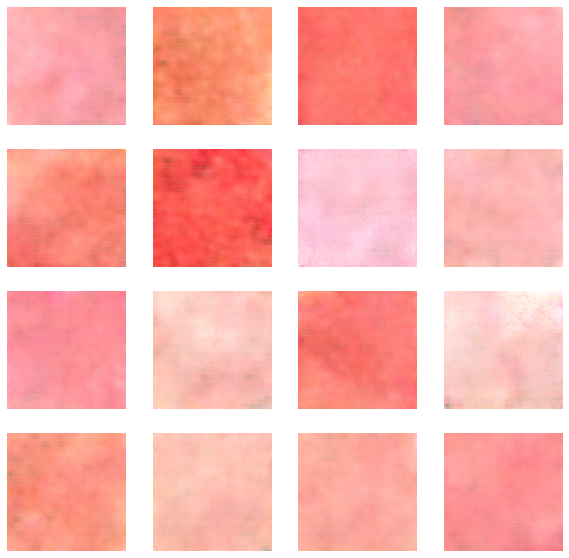

Time for epoch 5000 is 1.1596899032592773 sec


In [ ]:
train(dataset, 5000)

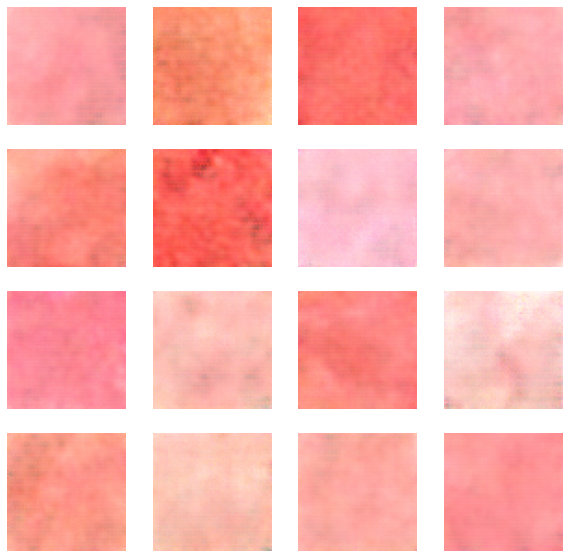

Time for epoch 5000 is 1.1476221084594727 sec


In [ ]:
train(dataset, 5000)

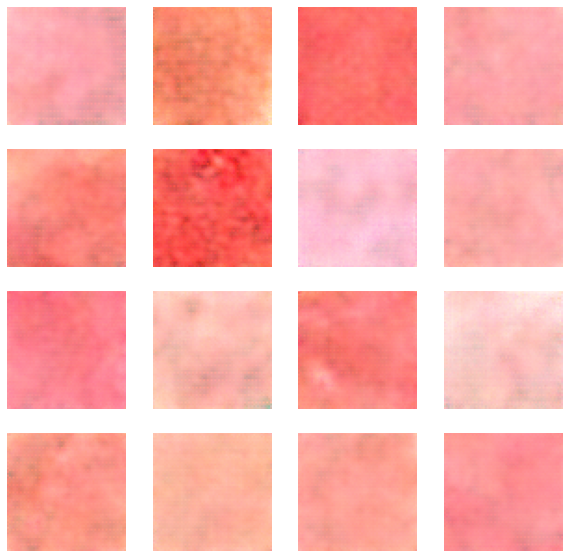

Time for epoch 5000 is 1.3634679317474365 sec


In [ ]:
train(dataset, 5000)

In [ ]:
import numpy as np
from tifffile import imsave
from PIL import Image

In [ ]:
def saved_images(model, epoch, test_input, index):
    predictions = model(test_input, training=False)
    for j in range(16):
        image = predictions[j] * 255
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)
        image.save('/content/drive/MyDrive/generatedReds/myReds_'+str(index+j)+'.jpg')

In [ ]:
for i in range(150):
  saved_images(g, 1, tf.random.normal([16, 1, 1, 128]),i*16)

In [ ]:
def saved_images1(model, epoch, test_input, index):
    predictions = model(test_input, training=False)
    for j in range(16):
        image = predictions[j] * 255
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)
        image.save('/content/drive/MyDrive/data_64_all/red/generatedReds/myReds_'+str(index+j)+'.jpg')

In [ ]:
for i in range(150):
  saved_images1(g, 1, tf.random.normal([16, 1, 1, 128]),i*16)

In [ ]:
def saved_images2(model, epoch, test_input, index):
    predictions = model(test_input, training=False)
    for j in range(16):
        image = predictions[j] * 255
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)
        image.save('/content/drive/MyDrive/data_64_2/홍진/generatedReds/myReds_'+str(index+j)+'.jpg')

In [ ]:
for i in range(150):
  saved_images1(g, 1, tf.random.normal([16, 1, 1, 128]),i*16)